# MSCA 31008 HW6
Sijie Li

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from mlxtend.plotting import plot_decision_regions
from sklearn import metrics
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import statistics as st

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Data Manipulation

In [5]:
Ddata=pd.read_csv(r'C:\Users\Sijie Li\OneDrive - The University of Chicago\Documents\MSCA\Winter2021\MsCA31008 DataMining\diabetes_preprocessed_nodummies.csv')

In [6]:
Ddata['change'].replace(('Yes'), 1,inplace=True)
Ddata['change'].replace(('No'), 0,inplace=True)

Ddata['gender'].replace(('Male'), 1,inplace=True)
Ddata['gender'].replace(('Female'), 0,inplace=True)
Ddata['gender'].replace(('Unknown/Invalid'), 2,inplace=True)

Ddata['diabetesMed'].replace(('Yes'), 1,inplace=True)
Ddata['diabetesMed'].replace(('No'), 0,inplace=True)
Ddata['readmitted'].replace(('YES', 'NO'), (1, 0), inplace=True)

In [7]:
Ddata['gender'] = Ddata['gender'].astype('int64')


In [8]:
cat_cols=['race','admission_type_id','discharge_disposition_id','diag_1', 'max_glu_serum', 'A1Cresult', 'metformin', 
     'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',  'glipizide', 'glyburide', 'tolbutamide', 
     'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 
     'glipizide-metformin','metformin-rosiglitazone']

In [9]:
newdf_dummies = pd.get_dummies(Ddata[cat_cols], drop_first=True)


In [11]:
noncat_cols = [col for col in Ddata.columns if col not in cat_cols]
noncat_cols

['gender',
 'age',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'change',
 'diabetesMed',
 'readmitted']

In [12]:
Ddata2 = pd.concat([Ddata[noncat_cols], newdf_dummies], axis=1)


In [13]:
Ddata2.shape


(71518, 74)

In [14]:
Ddata2.drop(['readmitted'], axis=1, inplace=True)


In [15]:
X1 = Ddata2
y1 = Ddata['readmitted']

In [16]:
y1.value_counts()


0    42985
1    28533
Name: readmitted, dtype: int64

0    42985
1    28533
Name: readmitted, dtype: int64


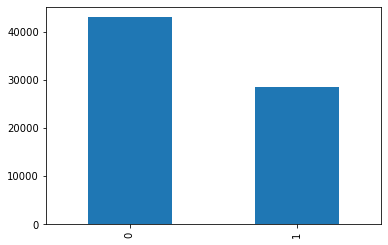

In [22]:
color_wheel = {1: "#0392cf", 
               2: "#7bc043"}
colors = Ddata['readmitted'].map(lambda x: color_wheel.get(x + 1))
print(Ddata.readmitted.value_counts())
p=Ddata.readmitted.value_counts().plot(kind="bar")

The above graph shows that the data is biased towards datapoints not readmitted value as 0. The number of not readmitted is 1/3 more than re-admitted.

In [23]:
#Split data in 70:30
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.3, random_state = 10,stratify=y1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((50062, 73), (21456, 73), (50062,), (21456,))

In [24]:
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Apply KNN Classifier

In [25]:
from sklearn.neighbors import KNeighborsClassifier

test_scores = []
train_scores = []

for i in range(1,5):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [26]:
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 99.99600495385722 % and k = [1]


In [27]:
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 57.96513795674869 % and k = [2]


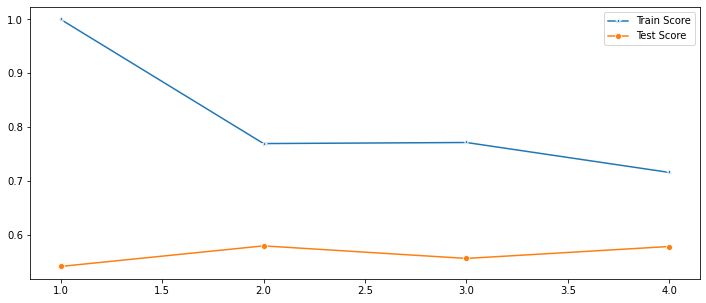

In [29]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,5),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,5),test_scores,marker='o',label='Test Score')

The best result is whwen k=2 for this dataset.

In [33]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(2)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.5796513795674869

## KNN Confusion Matrix

In [34]:
y_pred_knn = knn.predict(X_test)

In [54]:
knn_matrix = metrics.confusion_matrix(y_test, y_pred_knn)

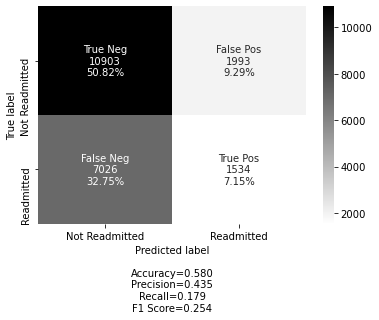

In [55]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Not Readmitted', 'Readmitted']
make_confusion_matrix(knn_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

# Support Vector Machines

In [57]:
svm_clf = Pipeline((        
  ("scaler", StandardScaler()),        
  ("linear_svc", LinearSVC(C=1, loss="hinge")),    
  ))
svm_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

In [58]:
svm_pred = svm_clf.predict(X_test)
svm_clf.score(X_test, y_test)

0.6184284116331096

## Confusion Matrix - SVM

In [59]:
svm_matrix = metrics.confusion_matrix(y_test, svm_pred)

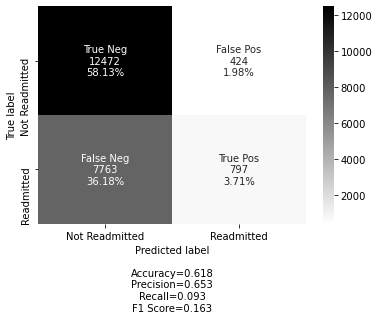

In [60]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Not Readmitted', 'Readmitted']
make_confusion_matrix(svm_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

# Naïve Bayes

In [62]:
cnb = CategoricalNB()
cnb.fit(X_train,y_train)

CategoricalNB()

In [63]:
cnb_pred = cnb.predict(X_test)
cnb.score(X_test,y_test)

0.5928877703206562

## Confusion Matrix

In [64]:
cnb_matrix = metrics.confusion_matrix(y_test, cnb_pred)

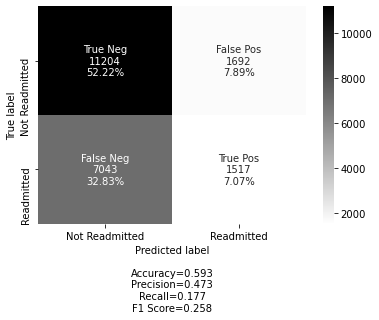

In [65]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Not Readmitted', 'Readmitted']
make_confusion_matrix(cnb_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

# Summary on KNN, SVM and CNB Model

By comparing the above three models on accuracy rate, although SVM has slightly higher accuracy rate at 61%, it is just a few % over the other two models. 

If we look at the true positive rate (the number of "YES" are truly predicted), KNN is sightly higher at 7.15% over all observations.

All the models predicted well on True Negative (readmitted "NO"), which could cause by the imbalanced target variables.Therefore, I am taking KNN as an example and calculate the ROC score. It helps us to understand how good the model can distinguish between two things (e.g If the patient has readmitted or not ). Better models can accurately distinguish between the two. Whereas, a poor model will have difficulties in distinguishing between the two. 

In [83]:
from sklearn.metrics import roc_auc_score
y_pred_knn_proba = knn.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred_knn_proba)

0.5329930874023098

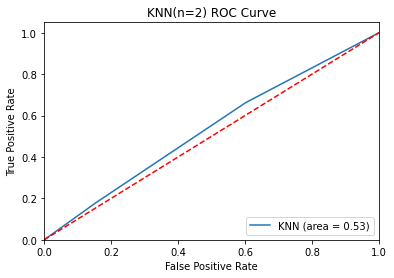

In [84]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_knn_proba)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN(n=2) ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR). The curve is close to the diagonal line, which indicates the model is average to poor.

# "Ensemble" model

In [ ]:
logisitic, Classification Trees, LDA, QDA, KNN, SVM, and Naïve Bayes

In [74]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(2),
    "Linear SVM": Pipeline((        
("scaler", StandardScaler()),        
  ("linear_svc", LinearSVC(C=1, loss="hinge")),    
  )),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": CategoricalNB(),
    "QDA":QuadraticDiscriminantAnalysis(priors=None, 
               store_covariance=False, tol=0.0001),
    "LDA":LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
}

In [77]:
DecisionTree = DecisionTreeClassifier()
KNN = KNeighborsClassifier(2)
Logistic= LogisticRegression()
SVM =Pipeline((        
("scaler", StandardScaler()),        
  ("linear_svc", LinearSVC(C=1, loss="hinge")),    
  ))
NaiveBayes = CategoricalNB()
LDA = LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
QDA = QuadraticDiscriminantAnalysis(priors=None, 
               store_covariance=False, tol=0.0001)

dt = DecisionTree.fit(X_train,y_train)
knn = KNN.fit(X_train,y_train)
lr = Logistic.fit(X_train,y_train)
svm = SVM.fit(X_train,y_train)
cnb = NaiveBayes.fit(X_train,y_train)
lda = LDA.fit(X_train,y_train)
qda = QDA.fit(X_train,y_train)

pred_dt=dt.predict(X_test)
pred_knn=knn.predict(X_test)
pred_lr=lr.predict(X_test)
pred_svm=svm.predict(X_test)
pred_cnb=cnb.predict(X_test)
pred_lda=lda.predict(X_test)
pred_qda=qda.predict(X_test)

final_pred = np.array([])
for i in range(0,len(X_test)):
    final_pred = np.append(final_pred, st.mode([pred_dt[i], pred_knn[i], pred_lr[i],pred_svm[i],
                                             pred_cnb[i], pred_lda[i],pred_qda[i]]))

In [79]:
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[('dt', dt), ('knn', knn),('lr', lr), ('svm', svm),
                                     ('cnb', cnb), ('lda', lda),('qda', qda)], voting='hard')
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.6216909023117076

In [80]:
model_pred = model.predict(X_test)

## Confusion Matrix

In [81]:
model_matrix = metrics.confusion_matrix(y_test, model_pred)

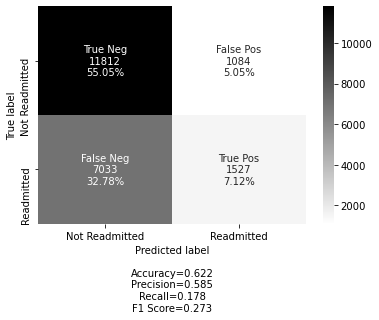

In [82]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Not Readmitted', 'Readmitted']
make_confusion_matrix(model_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

## Summary

Ensemble model did not yield a much better model accuracy or F1-score compared to the previous models. It might cause by the voting rule as the majarity true prediction won. The True negative is still the highest, and True positive has around 7% accuracy rate. 

To sum up, I do not think ensemble model is neccesary for this dataset as it yields similar prediction. Instead, we can probably try run indivisual model, that consists of the ensemble model and compare the performance metrics.
